In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.utils as utils
import torchvision
from torchsummary import summary

from albumentations.pytorch import ToTensor
import albumentations as A
from tqdm import tqdm
import random
import numpy as np
import cv2
from collections import OrderedDict

from PIL import Image, ImageDraw, ImageFont

from matplotlib import pyplot as plt
import time
import os

import pickle as pkl
from pathlib import Path

## Hyper-parameters

In [2]:
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001
RANDOM_SEED = 42

DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

## Helpers

In [3]:
def show_batch(x,y,shape = None):
    """
    input: 
        x(Tensor[num_images, rows, columns]): images tensor
        y(array): labels
        shape(tuple): (rows,col) 
    output:
        grid of smaple images
    """

    if not shape:
        shape = (int(x.shape[0]**0.5), int(x.shape[0]**0.5))

    fig, axs = plt.subplots(nrows= shape[0], ncols=shape[1], figsize = (12,8))
    index = 0
    for row in axs:
        for ax in row:
            ax.imshow(x[index])
            ax.set_xlabel(y[index], )
            index+=1
    # plt.subplots_adjust(wspace = 0.2, hspace = 0.5) 
    fig.tight_layout()
    plt.show()

## Dataset

In [4]:
root = Path("total_pic_patent")
char_set = set()
for direc in root.glob("*"):
    if direc.is_dir():
        for file in direc.glob("*.png"):
            if file.name != "origin.png":
                char = file.name[0]
                char_set.add(char)

len(char_set)

2470

In [5]:
"".join(char_set)

'代讼裕甸肃预离沾蛹拜咎娄浚玖抖撑腰掏畏伦钾熏周唆烘曹鳃忘鹅纲篮履绚眷职剐救亲羔辗狈芦搐段吉损琉徽狐线赎恰础倍留沉巩渗歪堵爱谢挟纠铁雇瓣忙吻颜争撒精舜刘席砚釉箭揩暑杰捅便疡樊蝗壹裙妈莹索西契剩丽灯呢甚词介笛希苛悟衅明洼者瘟啸牛警缆猩舒减坯夺器导囚幻缚涉乞库篷冀奠颁异翠示晋餐搽睫嘻外吝贾斑颊俄瀑蚜怨凋踌鲤连宋晕碉逆秆肾浩轴焙废臃疽响硝税剂罕汹淹梭桑葫抛门谤莱寺刃籍瘤颖禹博锣鄂母挛较地簿惑冶术馋憾丢沤炸届胺乙笨臣咽芍亭斜陀庆敖忠油策烤瞥偶推扩交悦划熔莆际跟悍驰谍回巷秉巫饲患窍改喝暇昭随晤噎试烁嚷阮块掺鸟舔呀饥胯捌肠要霹酱湛浦盲骏拯附淋湍锗搀钵凿泽饮芹雪美料碧磁饶妨稍赋态娶培墒互居缸苇误急潮缮辊抡拴贸扶娜候拒妄评诸甩拄赔腿楔觉惹柒事燃荐泥鼎松沛涸的封剖玛头浪素喉袒穴苟雨敬鬼婴衷消妥坞帧坷崔烯直恢颇狮踩滴栀济邦毫闽联序徒暂藉潍畜痰今煎霉胞镜均峙惰学搏煌茬葱庭趴社助呵点鼠郎捆落写滦泪糙贫公迂瘫硬虽本孝枕痒仇糊绪筒敢溢蕾犊短高视甜搭珐凰描啦冻敲葬款德渤受卵楞跳壤韭机馁识垦些奴肌冒抠祁痹溉系柔衡不特向疆吏拎混沁寂叶华涯炔派惯遏纷驳殖膏滞帜吠舞洁僳鞠余凯雕游桂敷躁琶钎历梗迟嘶揭痴盾菱选首谜尚命实徐娥骤保拭凌夹巨辖兢毅膛莎求柯度垃根玩赂阐裔毁禄署忌聂犯局全炕疮铸邓成禾值舍拉掀妖程揖憋萎胸真狼工瓤论并陈椽咸狄砾搬咱党人坪植苹间遣青伶既耪插杆日膨条范势侥翻愉彻或哦大革铲肤检皂峡兵几嚏屎缠搜蜘桃寝听寐裸孔趋烂娇洪氨像仍蜕吩键魂乎袄诺调肇萧缨邻剧硫族骚锤梁拦陆丧偷汐之熊盒篱顶佰诉旋谬朋叫藤协莽兆信疗顽舆碌绣加蝎癌娩列沪呼戎熙怎锌嘎国多镑式钦逐藩发燎望粗效纬布折嫁渊坏丁稚酮眩基击貉佛墟婶答去涩挠孕肝踢舱佣冲医溪锡腺龚靶透远木搅侠深孙洲茨藏冤徊辣整萝丸彭霜秽赶僻撮涤墓豪聊骋驾腕钝尾蜀茂枢舅盯镀煮紧眯弯越揽铆坟哑都绸桔叮织衔焰绕速葡瞎尖灵致存佯感孺性慑忱谱缅森橙虎拟汛窗翘证永步锑戍她悔钡讨捍馒攀晚痉缎谗骇兔朽投媳源诚纪会赃悠垯空劝胆雍侗亨姥坝某秘匿疫锁鹃袱茵颂夜蠢残燕绊骑吗旁辜帽栅抑味撩掸陛扫胜书蚁传围膀泅正献眶舰偏胚蓖删撅终结驯豌糟蒙按变呈爽逗剃鹊挂慰墙心烧汪蕴形于谋至抚涪腾刑吓掇蛤渭稻取眉舵渔湘驴才攻疵忿斩硅懒遥贰否遮氛濒兴辕倡氯来炭言它配铭苦臻格戊当拨笋纽低凉叔溯祷僧坊扒攘盼灶泣疑覆淬剔鸵橡表孽败缔欢矾我庚蹿批议队尘禁稿悉前例译饺症檀脯讹责蹦树咳渺液梧功釜棱撤拂诱唤究隧狸搔尽群案房夯触沥聚易

In [6]:
class PatentOCRTestDataset(Dataset):
      
    def __init__(self, root, char_set, transforms = None):

        self.root = root
        self.transforms = transforms    
        self.char_set = char_set
        
        
        self.char2index = {key:val for key,val in zip(char_set,range(len(char_set)))}
        self.index2char = {val:key for key,val in zip(char_set,range(len(char_set)))}
        
        self.samples = []
        self.labels = []
        
        for direc in root.glob("*"):
            if direc.is_dir():
                for file in direc.glob("*.png"):
                    if file.name != "origin.png":
                        self.samples.append(file)

        self.samples *= 5
        random.shuffle(self.samples)
        
        for p in self.samples:
            self.labels.append(self.char2index[p.name[0]])

    def __getitem__(self, index):

        img = self.samples[index]
        target = self.labels[index] 
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(image = img)["image"]

        return img, torch.tensor(target)
    
    def __len__(self):
        return len(self.samples)

In [7]:
transforms = A.Compose([
                        A.Resize(36,36),
                        A.Rotate(60,interpolation = cv2.INTER_LINEAR),
                        A.CenterCrop(32,32),
                        A.HueSaturationValue(p=0.3),
                        A.RandomBrightnessContrast(p=0.3),
                        A.ToGray(p=0.3),
                        A.OpticalDistortion(distort_limit=0.03, p = 0.3),
                        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                        ToTensor()
                    ])

dataset = PatentOCRTestDataset(root,char_set,transforms = transforms)


train_length = int(len(dataset) * 0.9)
val_length = len(dataset) - train_length

train_dataset, val_dataset = utils.data.random_split(dataset,[train_length, val_length])

train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
#                              num_workers=4,
                             shuffle=True)

val_dataloader = DataLoader(dataset = val_dataset,
                             batch_size=BATCH_SIZE,
#                              num_workers=4,
                             shuffle=False)

dataset_loader = {"train": train_dataloader, "val": val_dataloader}

if not os.path.exists("../models/patent_model_checkpoint"):
    os.makedirs("../models/patent_model_checkpoint")

with open("../models/patent_model_checkpoint/cache.pkl", "wb") as f:
    pkl.dump({"index2char": dataset.index2char},f)

In [8]:
image, target = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

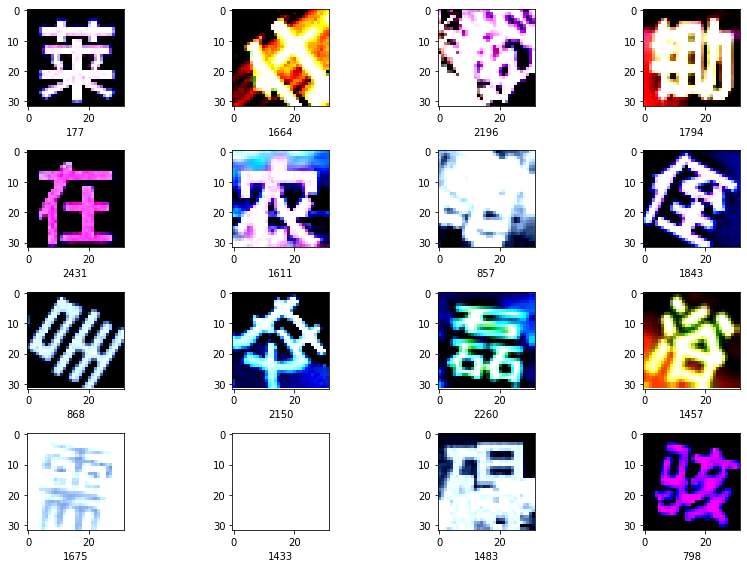

In [9]:
show_batch(image.permute([0,2,3,1]), target.numpy(), (4,4))

In [10]:
"".join([dataset.index2char[item] for item in target.numpy()])[:16]

'莱仕数锄在农蓖侄呈技磊浴需病碍骇'

## Model

In [11]:
class Model(nn.Module):
    def __init__(self, n_classes):
        super(Model, self).__init__()
        
        self.head = torch.nn.Sequential(
            torch.nn.Conv2d(3,64,kernel_size=(1,1),stride=(1,1),padding=(0,0),bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True)
        )
        
        base_model = torchvision.models.resnet34(pretrained=False)
        base_model_layers = list(base_model.children()) 
        
        self.body = torch.nn.Sequential(*base_model_layers[4:9])
        self.fc = torch.nn.Linear(in_features=512, out_features=n_classes, bias = True)
    
    
    def forward(self, x):
        x = self.head(x)
        x = self.body(x)
        x = x.view(-1, x.shape[1])
        logits = self.fc(x)
        probas = F.softmax(logits, dim = 1)
        return logits,probas
    
class PatentModel(nn.Module):
    def __init__(self, n_classes):
        super(PatentModel, self).__init__()
        
        self.upstream_model = Model(n_classes = 3755)
        checkpoint = torch.load("../models/ocr_pretrained_model_checkpoint/best_model.pt",map_location=DEVICE)
        self.upstream_model.load_state_dict(checkpoint["model_state_dict"])
        
        in_features = self.upstream_model.fc.in_features
        self.upstream_model.fc = torch.nn.Linear(in_features=in_features, out_features=n_classes, bias = True)

    def forward(self, x):
        logits,probas = self.upstream_model(x)
        return logits,probas

In [12]:
model = PatentModel(n_classes = len(char_set))
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=2,
        threshold=0.01,
        factor = 0.2,
        verbose=True,
        mode="max")

In [13]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             192
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [14]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    valid_acc_list = []
    best_valid_acc = 0
    
    for epoch in range(num_epochs):
        start = time.time()
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)
            
            _, predicted_labels = torch.max(probas, 1)
            correct_pred = (predicted_labels == targets).sum()
            train_acc = correct_pred.float() / targets.size(0) * 100
            
            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())
            
            if batch_idx % 100 == 0:
                
                print('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.3f} | Acc: {5:.3f} % \n'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss, train_acc))
                
                with open("train_log", "a") as f:
                    f.write('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.3f} | Acc: {5:.3f} \n'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss, train_acc))
        
        end = time.time()
        with torch.set_grad_enabled(False):
            
            valid_acc = metric_func(model, data_loader["val"], device)
            
            print('Epoch: {0:03d}/{1:03d} | val acc: {2:.3f} % | time: {3:.3f} s'.format(
                  epoch+1, num_epochs, valid_acc, end-start))
            
            with open("train_log","a") as f:
                f.write('Epoch: {0:03d}/{1:03d} | val acc: {2:.3f} % | time: {3:.3f} s \n'.format(
                  epoch+1, num_epochs, valid_acc, end-start))
            
            if not os.path.exists("../models/tyc_model_checkpoint"):
                os.mkdir("../models/tyc_model_checkpoint")
            
            if best_valid_acc < valid_acc:
                best_valid_acc = valid_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'valid_roc': valid_acc,
                    'optimizer_state_dict': optimizer.state_dict(),
                }, "../models/tyc_model_checkpoint/best_model.pt")
            
            valid_acc_list.append(valid_acc)
        
        scheduler.step(valid_acc)
            
    checkpoint = torch.load("../models/tyc_model_checkpoint/best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
            
    return model, loss_list, valid_acc_list

In [15]:
model, loss_list, valid_acc_list = train_model(model, 
            dataset_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE,
            metric_func = compute_accuracy)

Epoch: 001/020 | Batch 000/1134 | Loss: 9.011 | Acc: 0.000 % 

Epoch: 001/020 | Batch 100/1134 | Loss: 8.584 | Acc: 6.250 % 



KeyboardInterrupt: 

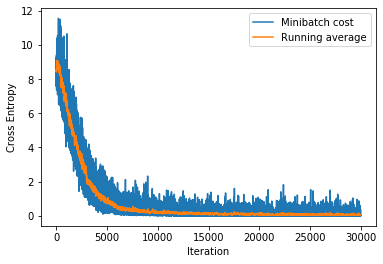

In [73]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(30,)/30, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

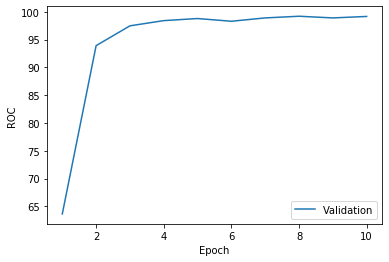

In [74]:
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()
plt.show()

In [87]:
test_transforms = A.Compose([
                        A.Resize(32,32),
#                         A.ToGray(),
                        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
                        ToTensor()
                    ])


class TycOCRTestDataset(Dataset):
      
    def __init__(self, root, char2index, transforms = None):

        self.samples = []
        self.labels = []        
        self.char2index = char2index
        
        self.transforms = transforms

        for direc in root.glob("*"):
            if direc.is_dir():
                source = direc / "0"
                target = direc / "1"

                target_set = set()

                for s_char in source.glob("*.png"):
                    char = s_char.name[0]
                    self.samples.append(s_char)
                    self.labels.append( self.char2index.get(char,-1) )
                      
                for t_char in target.glob("*.png"):
                    char = t_char.name[0]
                    self.samples.append(t_char)
                    self.labels.append(self.char2index.get(char,-1))
                    

    def __getitem__(self, index):

        img = self.samples[index]
        target = self.labels[index]        
        img = cv2.imread(str(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        img = self.transforms(image = img)["image"]

        return img,torch.tensor(target)
    
    def __len__(self):
        return len(self.samples)
    
    
test_dataset = TycOCRTestDataset(Path("test_data"), dataset.char2index, transforms = test_transforms )
test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size=32,
                             num_workers=4,
                             shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

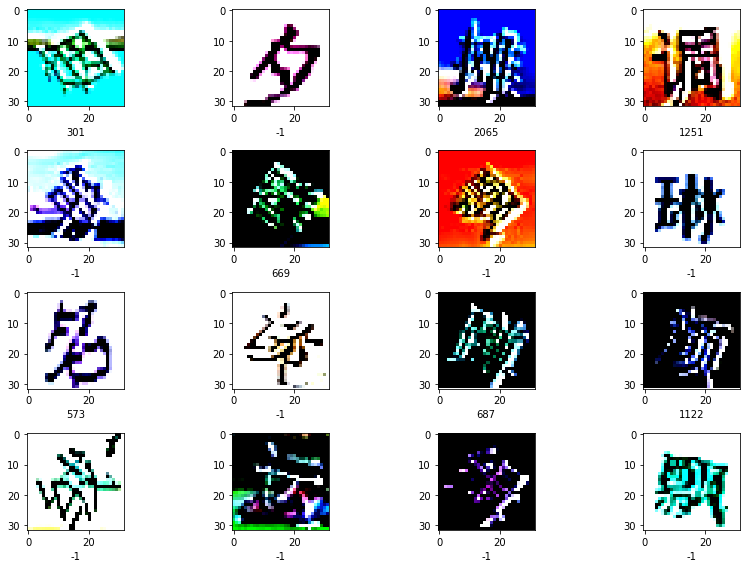

In [88]:
image, target = next(iter(test_dataloader))
show_batch(image.permute([0,2,3,1]), target.numpy(), (4,4))

In [90]:
model.eval()
all_preds = []
all_targets = []

for i, (features,targets) in enumerate(test_dataloader):
    features = features.to(DEVICE)
    logits,probas = model(features)
    _, predicted_labels = torch.max(probas, 1)
    all_preds += predicted_labels.tolist()
    all_targets += targets.tolist()

In [91]:
np.mean(np.array(all_preds) == np.array(all_targets))

0.4638888888888889